<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/reinforcement/SAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on **arXiv:1812.05905** "Soft Actor-Critic Algorithms and Applications"  
To make SAC work with discrete environments: Blended with **arXiv:1910.07207** "Soft Actor-Critic for Discrete Action Settings"  

Original paper **arXiv:1801.01290** "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor" useful for a fundemental understanding of the algorithm.

The stochastic temperature of the discrete SAC has problems (it has also been mentioned in the issues of the authors' github implementation) so it is disabled in favor of fixed temperature. I should make the stochastic temperature work and add any other improvements I find when I have the time.

In [1]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [6]:
import gym
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from torch.autograd import Variable
from torch.distributions.normal import Normal
from torch import distributions as pyd
import math

# Hyperparameters
BATCH_SIZE = 256
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
LR_ALPHA = 3e-4
STD_NOISE = 0.3
GAMMA = 0.99
TAU = 1e-3
BUFFER_SIZE = int(1e6)
STEPS = 1000
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
DELAY_STEPS = 2
EPSILON = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TanhTransform(pyd.transforms.Transform):
    domain = pyd.constraints.real
    codomain = pyd.constraints.interval(-1.0, 1.0)
    bijective = True
    sign = +1

    def __init__(self, cache_size=1):
        super().__init__(cache_size=cache_size)

    @staticmethod
    def atanh(x):
        return 0.5 * (x.log1p() - (-x).log1p())

    def __eq__(self, other):
        return isinstance(other, TanhTransform)

    def _call(self, x):
        return x.tanh()

    def _inverse(self, y):
        # We do not clamp to the boundary here as it may degrade the performance of certain algorithms.
        # one should use `cache_size=1` instead
        return self.atanh(y)

    def log_abs_det_jacobian(self, x, y):
        # We use a formula that is more numerically stable, see details in the following link
        # https://github.com/tensorflow/probability/commit/ef6bb176e0ebd1cf6e25c6b5cecdd2428c22963f#diff-e120f70e92e6741bca649f04fcd907b7
        return 2. * (math.log(2.) - x - F.softplus(-2. * x))

class SquashedNormal(pyd.transformed_distribution.TransformedDistribution):
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale

        self.base_dist = pyd.Normal(loc, scale)
        transforms = [TanhTransform()]
        super().__init__(self.base_dist, transforms)

    @property
    def mean(self):
        mu = self.loc
        for tr in self.transforms:
            mu = tr(mu)
        return mu

class ActorNet(torch.nn.Module):
    def __init__(self, state_size, action_size, max_action):
        super(ActorNet, self).__init__()

        self.fc1 = torch.nn.Linear(state_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.mu = torch.nn.Linear(128, action_size, device=device)
        self.sigma = torch.nn.Linear(128, action_size, device=device)
        self.max_action = max_action

        self.reset_parameters()

    def reset_parameters(self):
        x = self.fc1_init()
        self.fc1.weight.data.uniform_(x[0],x[1])
        x = self.fc2_init()
        self.fc2.weight.data.uniform_(x[0],x[1])

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # self.x1 = x
        x = F.relu(self.fc2(x))
        # self.x2 = x
        mu = self.mu(x)
        sigma = self.sigma(x)
        sigma = torch.clamp(sigma, min=EPSILON, max=1)

        return mu, sigma

    def sample_normal(self, x, reparameterize=True):
      mu, sigma = self.forward(x)

    #   if torch.isnan(mu).any():
    #     print(self.x1)
    #     print(self.x2)
    #     print(x)
    #     print(mu)
    #     print(sigma)

      probabilities = SquashedNormal(mu, sigma)

      if reparameterize:
        actions = probabilities.rsample()
      else:
        actions = probabilities.sample()

      log_probabilities = probabilities.log_prob(actions).sum(-1, keepdim=True)
      action = torch.tanh(actions) * torch.tensor(self.max_action)
    #   log_probabilities -= torch.log(1-action.pow(2) + EPSILON)
    #   log_probabilities = log_probabilities.sum(1, keepdim=True)

      return action, log_probabilities

class CriticNet(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNet, self).__init__()

        self.fc1 = torch.nn.Linear(state_size + action_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.fc3 = torch.nn.Linear(128, 1, device=device)

        self.fc4 = torch.nn.Linear(state_size + action_size, 256, device=device)
        self.fc5 = torch.nn.Linear(256, 128, device=device)
        self.fc6 = torch.nn.Linear(128, 1, device=device)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self.fc1_init())
        self.fc2.weight.data.uniform_(*self.fc2_init())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

        self.fc4.weight.data.uniform_(*self.fc1_init())
        self.fc5.weight.data.uniform_(*self.fc2_init())
        self.fc6.weight.data.uniform_(-3e-3, 3e-3)

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1).to(device)
        x = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        y = F.relu(self.fc4(state_action))
        y = F.relu(self.fc5(y))
        y = self.fc6(y)
        return x,y

    def Q1(self, state, action):
        state_action = torch.cat([state, action], 1).to(device)
        x = F.relu(self.fc1(state_action))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SAC:
    def __init__(self, state_dim, action_dim, action_high):
        self.actor = ActorNet(state_dim, action_dim, action_high)
        self.actor_target = ActorNet(state_dim, action_dim, action_high)
        self.critic = CriticNet(state_dim, action_dim)
        self.critic_target = CriticNet(state_dim, action_dim)
        self.memory = deque(maxlen=BUFFER_SIZE)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.action_high = action_high
        self.step = 0
        self.log_alpha = torch.tensor([-3.0], requires_grad=True, device=device)
        self.optimizer_logalpha = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        self.target_entropy = -action_dim

    def act(self, state):
        state = Variable(torch.from_numpy(state).float().to(device).unsqueeze(0))
        self.actor.eval()
        with torch.no_grad():
            action, _ = self.actor.sample_normal(state.to(device), False)
        self.actor.train()
        return np.clip(action.cpu().numpy()[0] * self.action_high, -self.action_high, self.action_high)

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return

        self.step += 1

        batch = random.sample(self.memory, BATCH_SIZE)
        state_batch = torch.from_numpy(np.array([arr[0] for arr in batch])).float().to(device)
        action_batch = torch.from_numpy(np.array([arr[1] for arr in batch])).float().to(device)
        reward_batch = torch.from_numpy(np.array([arr[2] for arr in batch]).reshape(BATCH_SIZE, 1)).float().to(device)
        next_state_batch = torch.from_numpy(np.array([arr[3] for arr in batch])).float().to(device)
        done_batch = torch.from_numpy(np.array([arr[4] for arr in batch], dtype=np.uint8).reshape(BATCH_SIZE, 1)).float().to(device)

        alpha = torch.exp(self.log_alpha)

        next_actions, log_probs = self.actor_target.sample_normal(next_state_batch)
        q_next1, q_next2 = self.critic_target(next_state_batch, next_actions)
        target_V = torch.min(q_next1,q_next2) - alpha.detach() * log_probs
        q_targets = reward_batch + GAMMA * target_V * (1 - done_batch)

        # Update critic
        self.optimizer_critic.zero_grad()
        q_current1, q_current2 = self.critic(state_batch, action_batch)
        critic_loss = F.mse_loss(q_current1, q_targets) + F.mse_loss(q_current2, q_targets)
        critic_loss.backward()
        self.optimizer_critic.step()

        if self.step % DELAY_STEPS == 0:
          # Update actor
          self.optimizer_actor.zero_grad()
          next_actions, log_probs = self.actor.sample_normal(state_batch)
          q_next1, q_next2 = self.critic(state_batch, next_actions)
          actor_Q = torch.min(q_next1,q_next2)
          actor_loss = (alpha.detach() * log_probs - actor_Q).mean()
          actor_loss.backward()
          self.optimizer_actor.step()

          # Update log_alpha
          self.optimizer_logalpha.zero_grad()
          alpha_loss = (alpha *
                              (-log_probs - self.target_entropy).detach()).mean()
          alpha_loss.backward()
          self.optimizer_logalpha.step()

          # Update target networks
          self.update_targets()

    def update_targets(self):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
if __name__ == "__main__":
    env = gym.make("Pendulum-v1")
    agent = SAC(env.observation_space.shape[0], env.action_space.shape[0], env.action_space.high[0])
    scores = []
    for i_episode in range(1, 150):
        state = env.reset()
        score = 0
        for t in range(1000):
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            agent.memorize(state, action, reward, next_state, done)
            agent.learn()
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        print("Episode {}: Score = {}".format(i_episode, score))

Episode 1: Score = -1761.0312384209321
Episode 2: Score = -1354.5920990192749
Episode 3: Score = -1586.7806975086564
Episode 4: Score = -1481.977678871135
Episode 5: Score = -1371.2764252748607
Episode 6: Score = -1332.1760130458483
Episode 7: Score = -1420.713161111439
Episode 8: Score = -1267.5330272078297
Episode 9: Score = -1219.1230345838408
Episode 10: Score = -1251.883917920184
Episode 11: Score = -1471.3816109385716
Episode 12: Score = -1381.122098309823
Episode 13: Score = -1649.2137797217915
Episode 14: Score = -1643.44847567679
Episode 15: Score = -1770.5761751313137
Episode 16: Score = -1713.140099151921
Episode 17: Score = -1743.5602933650985
Episode 18: Score = -1804.158444771253
Episode 19: Score = -1770.98134214173
Episode 20: Score = -1816.9951651934998
Episode 21: Score = -1743.3735579620593
Episode 22: Score = -1754.5808995882705
Episode 23: Score = -1766.1746514283905
Episode 24: Score = -1638.4149276880376
Episode 25: Score = -1466.6663648028582
Episode 26: Score =

In [ ]:
def create_actor_distribution(action_types, actor_output, action_size):
    """Creates a distribution that the actor can then use to randomly draw actions"""
    if action_types == "DISCRETE":
        assert actor_output.size()[1] == action_size, "Actor output the wrong size"
        action_distribution = Categorical(actor_output)  # this creates a distribution to sample from
    else:
        assert actor_output.size()[1] == action_size * 2, "Actor output the wrong size"
        means = actor_output[:, :action_size].squeeze(0)
        stds = actor_output[:,  action_size:].squeeze(0)
        if len(means.shape) == 2: means = means.squeeze(-1)
        if len(stds.shape) == 2: stds = stds.squeeze(-1)
        if len(stds.shape) > 1 or len(means.shape) > 1:
            raise ValueError("Wrong mean and std shapes - {} -- {}".format(stds.shape, means.shape))
        action_distribution = Normal(means.squeeze(0), torch.abs(stds))
    return action_distribution

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ActorNetDiscrete(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorNetDiscrete, self).__init__()

        self.fc1 = torch.nn.Linear(state_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.out = torch.nn.Linear(128, action_size, device=device)
        self.action_size = action_size

        self.reset_parameters()

    def reset_parameters(self):
        x = self.fc1_init()
        self.fc1.weight.data.uniform_(x[0],x[1])
        x = self.fc2_init()
        self.fc2.weight.data.uniform_(x[0],x[1])

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
            # print(x)
        x = F.relu(self.fc2(x))

        action_probs = torch.softmax(self.out(x), dim=-1)
        if action_probs.isnan().any():
            print('debug_in1')
            print(self.fc1.weight)

        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probs = torch.log(action_probs + z)

        action_distribution = create_actor_distribution("DISCRETE", action_probs, self.action_size)

        return action_distribution.sample(), action_probs, log_action_probs

class CriticNetDiscrete(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetDiscrete, self).__init__()

        self.fc1 = torch.nn.Linear(state_size, 256, device=device)
        self.fc2 = torch.nn.Linear(256, 128, device=device)
        self.fc3 = torch.nn.Linear(128, action_size, device=device)

        self.fc4 = torch.nn.Linear(state_size, 256, device=device)
        self.fc5 = torch.nn.Linear(256, 128, device=device)
        self.fc6 = torch.nn.Linear(128, action_size, device=device)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self.fc1_init())
        self.fc2.weight.data.uniform_(*self.fc2_init())
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

        self.fc4.weight.data.uniform_(*self.fc1_init())
        self.fc5.weight.data.uniform_(*self.fc2_init())
        self.fc6.weight.data.uniform_(-3e-3, 3e-3)

    def fc1_init(self):
        lim = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        return (-lim, lim)

    def fc2_init(self):
        lim = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        return (-lim, lim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        y = F.relu(self.fc4(state))
        y = F.relu(self.fc5(y))
        y = self.fc6(y)
        return x,y

class SACDiscrete:
    def __init__(self, env, state_dim):
        action_dim = env.action_space.n

        self.actor = ActorNetDiscrete(state_dim, action_dim)
        self.actor_target = ActorNetDiscrete(state_dim, action_dim)
        self.critic = CriticNetDiscrete(state_dim, action_dim)
        self.critic_target = CriticNetDiscrete(state_dim, action_dim)
        self.memory = deque(maxlen=BUFFER_SIZE)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.step = 0
        self.log_alpha = torch.tensor([10.0], requires_grad=True, device=device)
        self.optimizer_logalpha = optim.Adam([self.log_alpha], lr=LR_ALPHA)
        self.target_entropy = -math.log(1/action_dim)

    def act(self, state):
        state = Variable(torch.from_numpy(state).float().to(device).unsqueeze(0))
        self.actor.eval()
        with torch.no_grad():
            action, _, _ = self.actor(state.to(device))
        self.actor.train()
        return action

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return

        self.step += 1

        batch = random.sample(self.memory, BATCH_SIZE)
        state_batch = torch.from_numpy(np.array([arr[0] for arr in batch])).float().to(device)
        action_batch = torch.from_numpy(np.array([arr[1] for arr in batch])).float().to(device).unsqueeze(dim=-1)
        reward_batch = torch.from_numpy(np.array([arr[2] for arr in batch]).reshape(BATCH_SIZE, 1)).float().to(device)
        next_state_batch = torch.from_numpy(np.array([arr[3] for arr in batch])).float().to(device)
        done_batch = torch.from_numpy(np.array([arr[4] for arr in batch], dtype=np.uint8).reshape(BATCH_SIZE, 1)).float().to(device)

        alpha = torch.tensor([0.2], device=device)
        # alpha = self.log_alpha

        next_actions, action_probs, log_action_probs = self.actor_target(next_state_batch)
  
        next_actions = next_actions.unsqueeze(dim=-1)
        q_next1, q_next2 = self.critic_target(next_state_batch)
        # log(next_actions) is log_probs in this case
        target_V = (action_probs * (torch.min(q_next1,q_next2) - alpha.detach() * log_action_probs)).sum(dim=1, keepdims=True)
        q_targets = reward_batch + GAMMA * target_V * (1 - done_batch)

        # Update critic
        self.optimizer_critic.zero_grad()
        q_current1, q_current2 = self.critic(state_batch)
        critic_loss = F.mse_loss(q_current1.gather(1, action_batch.long()), q_targets) + F.mse_loss(q_current2.gather(1, action_batch.long()), q_targets)
        losses_critic.append(critic_loss.item())
        critic_loss.backward()
        self.optimizer_critic.step()

        if self.step % 2 == 0:
          # Update actor
          self.optimizer_actor.zero_grad()
          next_actions, action_probs, log_action_probs = self.actor(state_batch)
          next_actions = next_actions.unsqueeze(dim=-1)
          q_next1, q_next2 = self.critic(state_batch)
          actor_Q = torch.min(q_next1,q_next2)
          actor_loss = (action_probs * (alpha.detach() * log_action_probs - actor_Q)).sum(dim=1).mean()
          losses_actor.append(actor_loss.item())
          actor_loss.backward()
          self.optimizer_actor.step()

          # Update log_alpha
        #   self.optimizer_logalpha.zero_grad()
        #   alpha_loss = (action_probs.detach() * -alpha *
                            #   (log_action_probs.detach() + self.target_entropy)).sum(dim=1).mean()
        #   losses_alpha.append(alpha_loss.item())
        #   alpha_loss.backward()
        #   self.optimizer_logalpha.step()

          # Update target networks
          self.update_targets()

    def update_targets(self):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

In [ ]:
if __name__ == "__main__":
    env = gym.make("LunarLander-v2")
    agent = SACDiscrete(env, env.observation_space.shape[0])
    scores = []
    for i_episode in range(1, 2000):
        state = env.reset()
        score = 0
        for t in range(400):
            action = agent.act(state)
            next_state, reward, done, info = env.step(action.item())
            agent.memorize(state, action.item(), reward, next_state, done)
            agent.learn()
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        print("Episode {}: Score = {}".format(i_episode, score))

Episode 1: Score = 2.7475099244149135
Episode 2: Score = -129.70563448217
Episode 3: Score = -300.20287863951205
Episode 4: Score = -93.37365654104593
Episode 5: Score = -92.43275526749474
Episode 6: Score = -141.9990323614752
Episode 7: Score = -323.96654596381745
Episode 8: Score = -213.26839719331738
Episode 9: Score = -79.45376390149676
Episode 10: Score = -309.87314886552053
Episode 11: Score = -69.9627583427856
Episode 12: Score = -21.364506046839296
Episode 13: Score = -270.8319024520883
Episode 14: Score = -331.0200602291136
Episode 15: Score = -181.9210357738939
Episode 16: Score = -194.07302780892763
Episode 17: Score = -124.65835799526151
Episode 18: Score = -91.05746688743895
Episode 19: Score = -214.29702933082905
Episode 20: Score = -133.1387298067137
Episode 21: Score = -80.27008636498923
Episode 22: Score = -283.73212081240865
Episode 23: Score = -205.46287196932843
Episode 24: Score = -51.03715542763627
Episode 25: Score = -67.82966010556716
Episode 26: Score = -46.658

KeyboardInterrupt: ignored

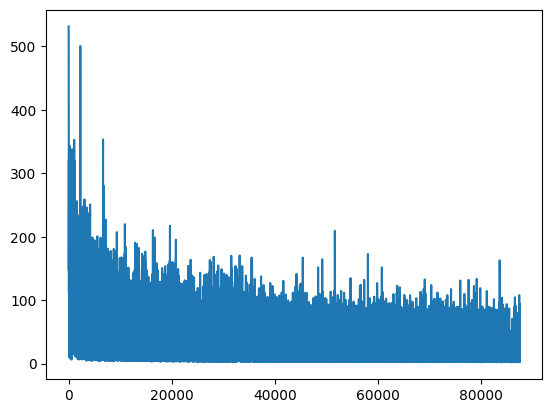

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses_critic)

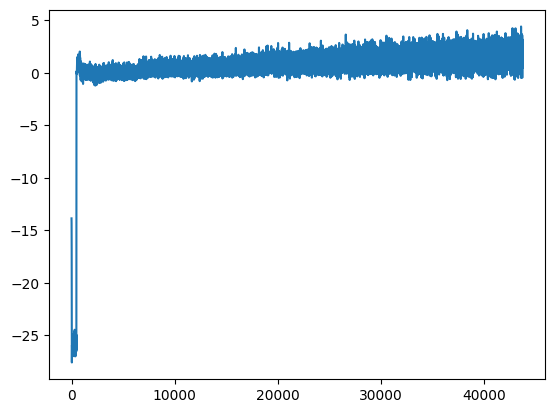

In [ ]:
plt.plot(losses_actor)

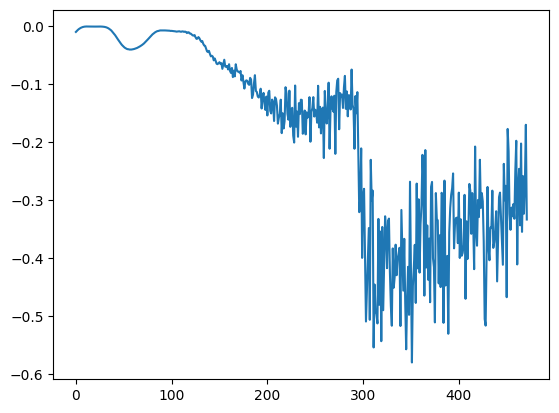

In [ ]:
plt.plot(losses_alpha)